In [1]:
import numpy as np
import pandas as pd
import cv2
import functools

import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.model_selection import train_test_split

from model_testing import ModelSelection
from plotting import show_distribution
from plot_val import calc_roc_curve, plot_roc_curve, plot_confusion_matrix

from apply_processing import apply, resize_images, function_rgb, function_gray
from apply_processing import function_label, blur_images, adjust_contrast_images, rotated_labels
from apply_processing import filter_images, edge_images, contour_images, rotate_images

In [2]:
df = pd.read_csv("Dataset\\images_mushrooms.csv")

df.head()

,Image,Label
0,Dataset\Mushrooms\Agaricus\009_mrv34Sn4WiQ.jpg,Agaricus
1,Dataset\Mushrooms\Agaricus\010_Rk1D3EG856g.jpg,Agaricus
2,Dataset\Mushrooms\Agaricus\017_QHGfbEiWvq8.jpg,Agaricus
3,Dataset\Mushrooms\Agaricus\020_vZJfrjIwmqU.jpg,Agaricus
4,Dataset\Mushrooms\Agaricus\030_-i6kYqDvBQo.jpg,Agaricus


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900 entries, 0 to 899
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Image   900 non-null    object
 1   Label   900 non-null    object
dtypes: object(2)
memory usage: 14.2+ KB


In [4]:
df['Label'].value_counts()

Boletus        100
Cortinarius    100
Entoloma       100
Lactarius      100
Suillus        100
Agaricus       100
Hygrocybe      100
Amanita        100
Russula        100
Name: Label, dtype: int64

# Processing the images

## No Augmentation

In [5]:
# Fixed contrast, brightness, sharpness

def processing_noAug(df):
    images = df['Image']
    labels = df["Label"]
    
    size = (150, 150)
    
    mod_images = function_rgb(images)
    mod_images = resize_images(mod_images, size)
    mod_images = filter_images(mod_images)
    mod_images = adjust_contrast_images(mod_images, contrast=1.5, brightness=-10)
    mod_images = blur_images(mod_images)
    
    return mod_images, labels

images_noAug, labels_noAug = processing_noAug(df)

## Augmentation function

In [6]:
# With Contour + Fixed contrast, brightness, sharpness

def processing_contour(df):
    images = df['Image']
    labels = df['Label']
    
    size = (150, 150)
    contrast = 1.5
    brightness = -10
    
    images_rgb = function_rgb(images)
    images_rgb = resize_images(images_rgb, size)
    images_rgb = filter_images(images_rgb)
    images_rgb = adjust_contrast_images(images_rgb, contrast=contrast, brightness=brightness)
    images_rgb = blur_images(images_rgb)
    
    images_gray = function_gray(images)
    images_gray = resize_images(images_gray, size)
    images_gray = filter_images(images_gray)
    images_gray = adjust_contrast_images(images_gray, contrast=contrast, brightness=brightness)
    images_gray = blur_images(images_gray)
    
    edged_images = edge_images(images_gray)
    
    images_contour = contour_images(edged_images, images_rgb)
    
    return list(images_contour)

In [7]:
# Random Contrast, Brightness, Sharpness

def processing_random(df):
    images = df['Image']
    labels = df['Label']
    
    size = (150, 150)
    contrast = np.random.randint(1, 5)
    brightness = np.random.randint(-100, 100)
    
    images_rgb = function_rgb(images)
    images_rgb = resize_images(images_rgb, size)
    images_rgb = filter_images(images_rgb)
    images_rgb = adjust_contrast_images(images_rgb, contrast=contrast, brightness=brightness)
    images_rgb = blur_images(images_rgb)
    
    return list(images_rgb)

In [8]:
# Fixed contrast, brightness, sharpness

def processing_fixed(df):
    images = df['Image']
    labels = df['Label']
    
    size = (150, 150)
    contrast = 1.5
    brightness = -10
    
    images_rgb = function_rgb(images)
    images_rgb = resize_images(images_rgb, size)
    images_rgb = filter_images(images_rgb)
    images_rgb = adjust_contrast_images(images_rgb, contrast=contrast, brightness=brightness)
    images_rgb = blur_images(images_rgb)
    
    return list(images_rgb)

In [9]:
# Rotated and flipped images

def processing_rotated(df):
    images = df['Image']
    labels = df['Label']
    
    size = (150, 150)
    contrast = 1.5
    brightness = -10
    
    images_rgb = function_rgb(images)
    images_rgb = resize_images(images_rgb, size)
    images_rgb = filter_images(images_rgb)
    images_rgb = adjust_contrast_images(images_rgb, contrast=contrast, brightness=brightness)
    images_rgb = blur_images(images_rgb)
    images_rgb = rotate_images(images_rgb)
    
    return list(images_rgb)

In [10]:
functions = [processing_contour, processing_random, processing_fixed]
labels = [function_label, function_label, function_label]

images_aug, labels_aug = apply(functions, labels, df)

# Images info

In [11]:
print(f"Length of images no augmentation {len(images_noAug)}")
print(f"Length of images with augmentation {len(images_aug)}")

Length of images no augmentation 900
Length of images with augmentation 2700


## Images info no augmentation

In [12]:
show_distribution(images_noAug)

## Images info augmentation

In [13]:
show_distribution(images_aug)

# Modelling with no augmentation

## Reduction with PCA

In [14]:
scaler = MinMaxScaler()
le = LabelEncoder()

pca = PCA(n_components=100)

In [15]:
images = [np.ravel(image) for image in images_noAug]

images_scaled = scaler.fit_transform(images)
labels_encoded = le.fit_transform(df["Label"])

In [16]:
images_pca = pca.fit_transform(images_scaled, labels_encoded)

images_pca_df = pd.DataFrame(data=images_pca)
images_pca_df["Label"] = le.inverse_transform(labels_encoded)

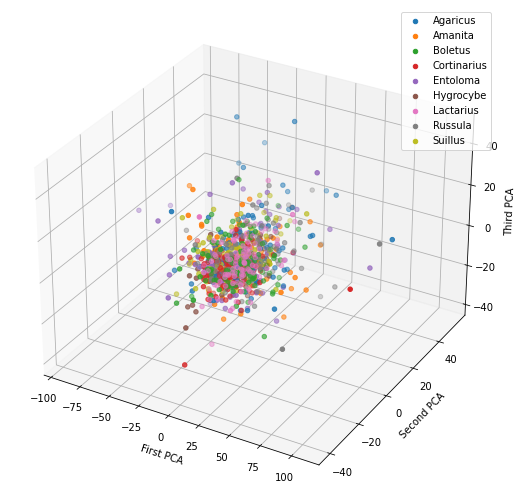

In [17]:
fig = plt.figure(figsize=(15,9))

ax = fig.add_subplot(projection='3d')

for label in images_pca_df["Label"].unique():
    first_pca = images_pca_df[images_pca_df["Label"] == label][0]
    second_pca = images_pca_df[images_pca_df["Label"] == label][1]
    third_pca = images_pca_df[images_pca_df["Label"] == label][2]
    
    ax.scatter(first_pca, second_pca, third_pca, label=label)
    
ax.legend()

ax.set_xlabel("First PCA")
ax.set_ylabel("Second PCA")
ax.set_zlabel("Third PCA")

plt.show()

## Modelling

In [18]:
X = images_pca_df.drop(columns=["Label"])
y = pd.Series(le.fit_transform(images_pca_df["Label"]))

### Using train_test_split

In [19]:
selection = ModelSelection(X, y, [RandomForestClassifier(), DecisionTreeClassifier(), MLPClassifier(), SVC()])

In [20]:
selection.use_train_test_split()

Model info
--------------------
Model name : RandomForestClassifier
Model name : DecisionTreeClassifier
Model name : MLPClassifier
Model name : SVC

Training models
--------------------
Done Training RandomForestClassifier in time:0.8006575107574463
Done Training DecisionTreeClassifier in time:0.8638961315155029


C:\Users\Bina Umat\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Done Training MLPClassifier in time:2.734872579574585
Done Training SVC in time:3.000654697418213
--------------------
Done Training models in time : 3.000654697418213


The Scores :

Train RandomForestClassifier score : 1.0
Train DecisionTreeClassifier score : 1.0
Train MLPClassifier score : 1.0
Train SVC score : 0.8424543946932007
----------
Test RandomForestClassifier score : 0.21548821548821548
Test DecisionTreeClassifier score : 0.13468013468013468
Test MLPClassifier score : 0.16498316498316498
Test SVC score : 0.25925925925925924
----------
Bias RandomForestClassifier score : 0.7845117845117845
Bias DecisionTreeClassifier score : 0.8653198653198653
Bias MLPClassifier score : 0.835016835016835
Bias SVC score : 0.5831951354339415
----------


### Using StratifiedKFold

In [21]:
selection = ModelSelection(X, y, [RandomForestClassifier(), DecisionTreeClassifier(), MLPClassifier(), SVC()])

In [22]:
selection.use_stratifiedkfold()

Fold 1
----------

Training models

--------------------
Done Training RandomForestClassifier in time:1.0135762691497803

The Scores :

Train RandomForestClassifier score : 1.0
Test RandomForestClassifier score : 0.21666666666666667
Bias RandomForestClassifier score : 0.7833333333333333

--------------------
Done Training DecisionTreeClassifier in time:1.128943920135498

The Scores :

Train DecisionTreeClassifier score : 1.0
Test DecisionTreeClassifier score : 0.1388888888888889
Bias DecisionTreeClassifier score : 0.8611111111111112


C:\Users\Bina Umat\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(



--------------------
Done Training MLPClassifier in time:2.9704926013946533

The Scores :

Train MLPClassifier score : 1.0
Test MLPClassifier score : 0.21666666666666667
Bias MLPClassifier score : 0.7833333333333333

--------------------
Done Training SVC in time:3.229586362838745

The Scores :

Train SVC score : 0.8305555555555556
Test SVC score : 0.2611111111111111
Bias SVC score : 0.5694444444444444
--------------------
Done Training models in time : 3.229586362838745

Fold 2
----------

Training models

--------------------
Done Training RandomForestClassifier in time:0.7917969226837158

The Scores :

Train RandomForestClassifier score : 1.0
Test RandomForestClassifier score : 0.18888888888888888
Bias RandomForestClassifier score : 0.8111111111111111

--------------------
Done Training DecisionTreeClassifier in time:0.876004695892334

The Scores :

Train DecisionTreeClassifier score : 1.0
Test DecisionTreeClassifier score : 0.1388888888888889
Bias DecisionTreeClassifier score : 0.

C:\Users\Bina Umat\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(



--------------------
Done Training MLPClassifier in time:2.809893846511841

The Scores :

Train MLPClassifier score : 1.0
Test MLPClassifier score : 0.2
Bias MLPClassifier score : 0.8

--------------------
Done Training SVC in time:3.1443727016448975

The Scores :

Train SVC score : 0.8402777777777778
Test SVC score : 0.2388888888888889
Bias SVC score : 0.6013888888888889
--------------------
Done Training models in time : 3.1443727016448975

Fold 3
----------

Training models

--------------------
Done Training RandomForestClassifier in time:0.8419704437255859

The Scores :

Train RandomForestClassifier score : 1.0
Test RandomForestClassifier score : 0.21666666666666667
Bias RandomForestClassifier score : 0.7833333333333333

--------------------
Done Training DecisionTreeClassifier in time:0.9122738838195801

The Scores :

Train DecisionTreeClassifier score : 1.0
Test DecisionTreeClassifier score : 0.1388888888888889
Bias DecisionTreeClassifier score : 0.8611111111111112


C:\Users\Bina Umat\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(



--------------------
Done Training MLPClassifier in time:2.850149154663086

The Scores :

Train MLPClassifier score : 1.0
Test MLPClassifier score : 0.18888888888888888
Bias MLPClassifier score : 0.8111111111111111

--------------------
Done Training SVC in time:3.1089932918548584

The Scores :

Train SVC score : 0.8541666666666666
Test SVC score : 0.2611111111111111
Bias SVC score : 0.5930555555555554
--------------------
Done Training models in time : 3.1099331378936768

Fold 4
----------

Training models

--------------------
Done Training RandomForestClassifier in time:0.7607252597808838

The Scores :

Train RandomForestClassifier score : 1.0
Test RandomForestClassifier score : 0.2
Bias RandomForestClassifier score : 0.8

--------------------
Done Training DecisionTreeClassifier in time:0.83072829246521

The Scores :

Train DecisionTreeClassifier score : 1.0
Test DecisionTreeClassifier score : 0.12222222222222222
Bias DecisionTreeClassifier score : 0.8777777777777778


C:\Users\Bina Umat\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(



--------------------
Done Training MLPClassifier in time:2.6904704570770264

The Scores :

Train MLPClassifier score : 1.0
Test MLPClassifier score : 0.23333333333333334
Bias MLPClassifier score : 0.7666666666666666

--------------------
Done Training SVC in time:2.9489707946777344

The Scores :

Train SVC score : 0.8361111111111111
Test SVC score : 0.26666666666666666
Bias SVC score : 0.5694444444444444
--------------------
Done Training models in time : 2.9489707946777344

Fold 5
----------

Training models

--------------------
Done Training RandomForestClassifier in time:0.7816472053527832

The Scores :

Train RandomForestClassifier score : 1.0
Test RandomForestClassifier score : 0.19444444444444445
Bias RandomForestClassifier score : 0.8055555555555556

--------------------
Done Training DecisionTreeClassifier in time:0.8592634201049805

The Scores :

Train DecisionTreeClassifier score : 1.0
Test DecisionTreeClassifier score : 0.08888888888888889
Bias DecisionTreeClassifier score

C:\Users\Bina Umat\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(



--------------------
Done Training MLPClassifier in time:2.614734411239624

The Scores :

Train MLPClassifier score : 1.0
Test MLPClassifier score : 0.2111111111111111
Bias MLPClassifier score : 0.7888888888888889

--------------------
Done Training SVC in time:2.896031618118286

The Scores :

Train SVC score : 0.8430555555555556
Test SVC score : 0.2722222222222222
Bias SVC score : 0.5708333333333333
--------------------
Done Training models in time : 2.896031618118286


The Mean Scores :

Train mean RandomForestClassifier score : 1.0
Train mean DecisionTreeClassifier score : 1.0
Train mean MLPClassifier score : 1.0
Train mean SVC score : 0.8430555555555556
----------
Test mean RandomForestClassifier score : 0.19444444444444445
Test mean DecisionTreeClassifier score : 0.08888888888888889
Test mean MLPClassifier score : 0.2111111111111111
Test mean SVC score : 0.2722222222222222
----------
Bias mean RandomForestClassifier score : 0.8055555555555556
Bias mean DecisionTreeClassifier scor

## Evaluation

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [24]:
svm = SVC(probability=True)
dtc = DecisionTreeClassifier()
mlpc = MLPClassifier()
rfc = RandomForestClassifier()

In [25]:
svm.fit(X_train, y_train)
dtc.fit(X_train, y_train)
mlpc.fit(X_train, y_train)
rfc.fit(X_train, y_train)

C:\Users\Bina Umat\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


RandomForestClassifier()

### ROC Curve and AUC

In [26]:
svm_proba = svm.predict_proba(X_test)
dtc_proba = dtc.predict_proba(X_test)
mlpc_proba = mlpc.predict_proba(X_test)
rfc_proba = rfc.predict_proba(X_test)

In [27]:
fprs_svm, tprs_svm, aucs_svm = calc_roc_curve(y_test, svm_proba)
fprs_dtc, tprs_dtc, aucs_dtc = calc_roc_curve(y_test, dtc_proba)
fprs_mlpc, tprs_mlpc, aucs_mlpc = calc_roc_curve(y_test, mlpc_proba)
fprs_rfc, tprs_rfc, aucs_rfc = calc_roc_curve(y_test, rfc_proba)

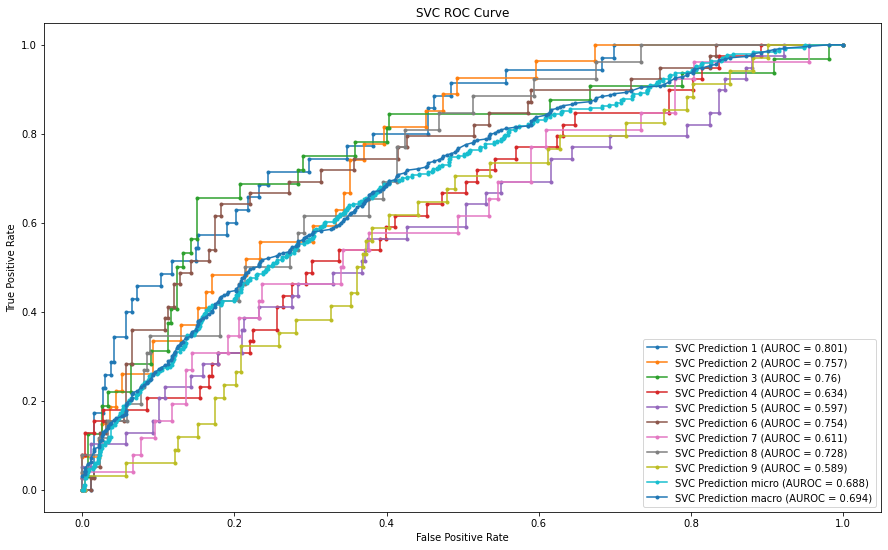

In [28]:
fig = plt.figure(figsize=(15, 9))

plot_roc_curve(fprs_svm, tprs_svm, aucs_svm, "SVC")

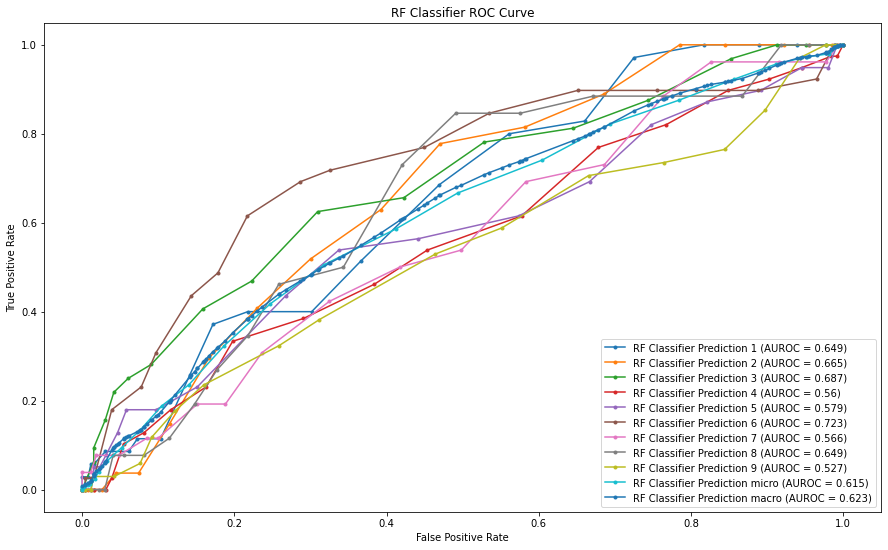

In [29]:
fig = plt.figure(figsize=(15, 9))

plot_roc_curve(fprs_rfc, tprs_rfc, aucs_rfc, "RF Classifier")

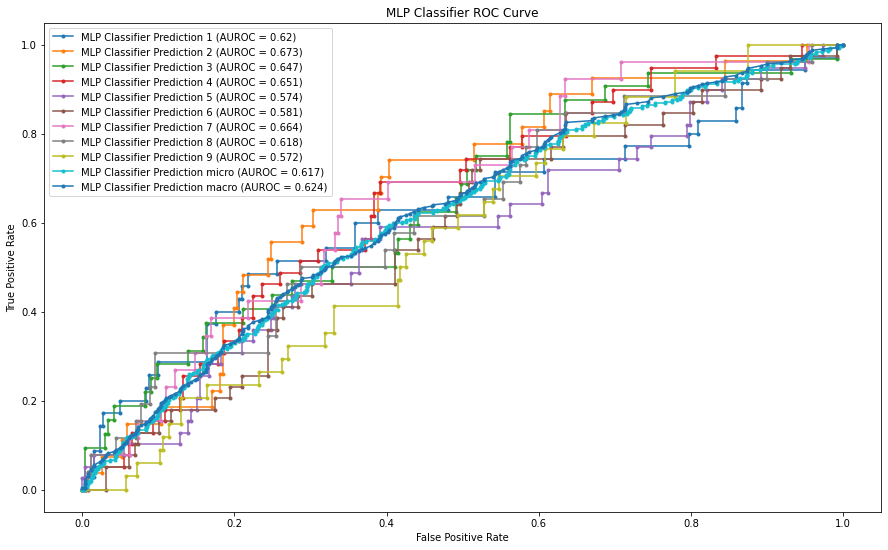

In [30]:
fig = plt.figure(figsize=(15, 9))

plot_roc_curve(fprs_mlpc, tprs_mlpc, aucs_mlpc, "MLP Classifier")

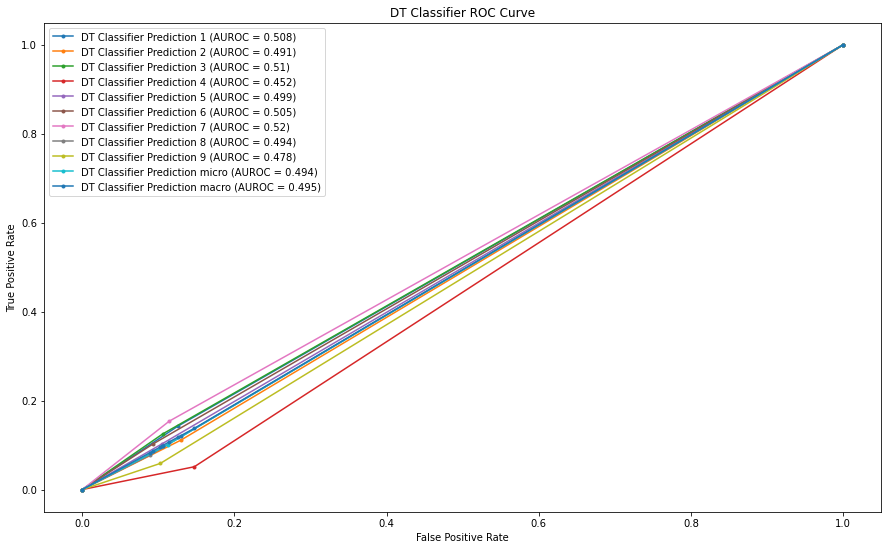

In [31]:
fig = plt.figure(figsize=(15, 9))

plot_roc_curve(fprs_dtc, tprs_dtc, aucs_dtc, "DT Classifier")

### Confusion Matrix

In [32]:
svm_pred = svm.predict(X_test)
dtc_pred = dtc.predict(X_test)
mlpc_pred = mlpc.predict(X_test)
rfc_pred = rfc.predict(X_test)

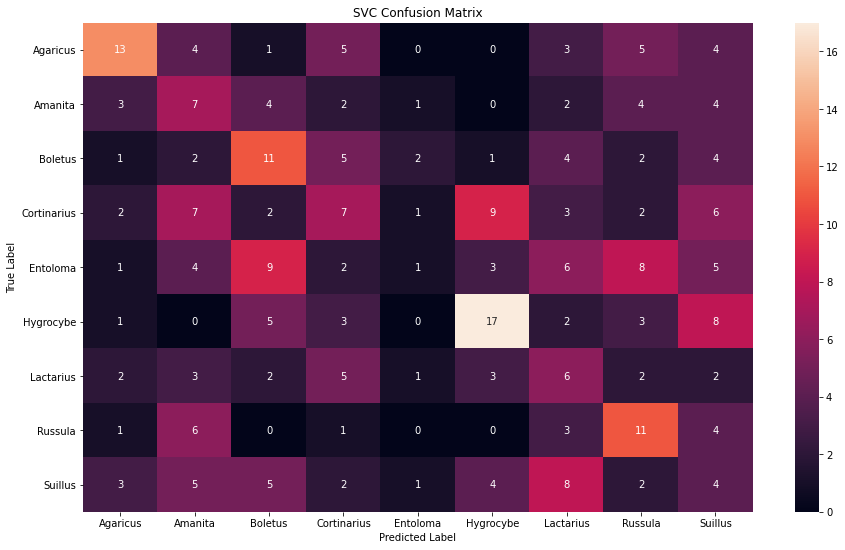

In [33]:
fig = plt.figure(figsize=(15, 9))

plot_confusion_matrix(df["Label"], y_test, svm_pred, 'SVC')

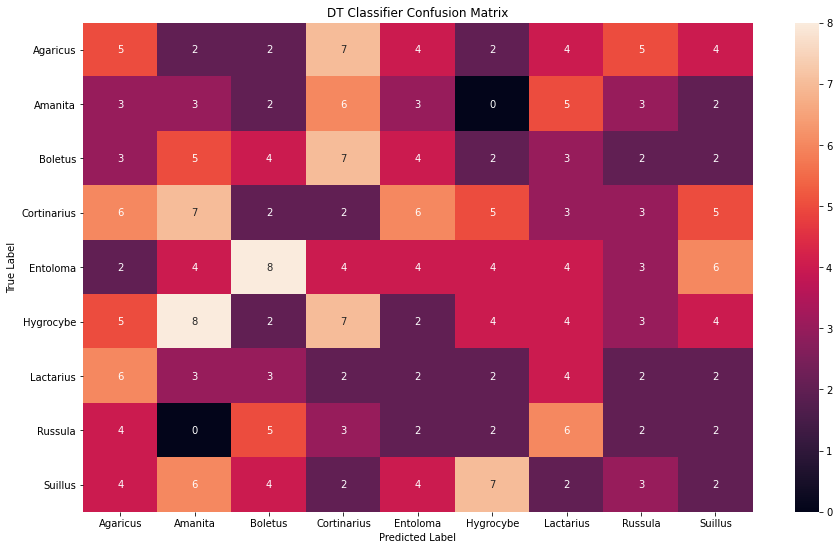

In [34]:
fig = plt.figure(figsize=(15, 9))

plot_confusion_matrix(df["Label"], y_test, dtc_pred, 'DT Classifier')

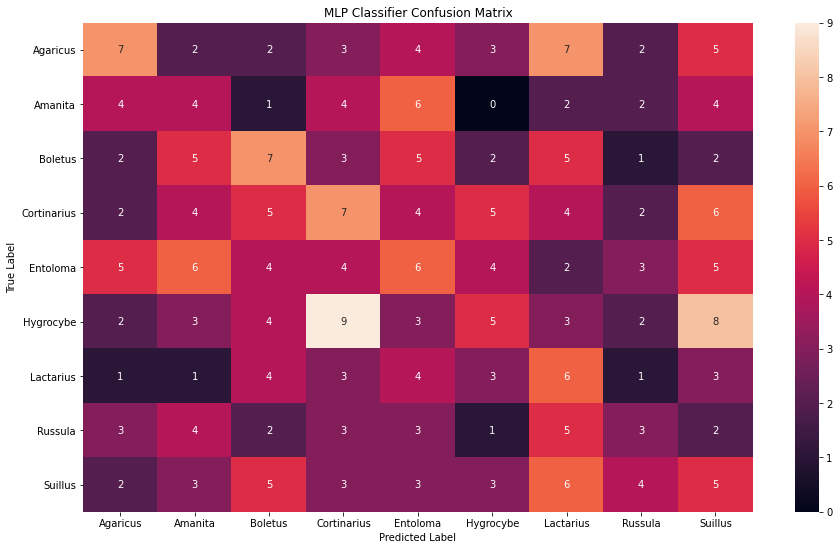

In [35]:
fig = plt.figure(figsize=(15, 9))

plot_confusion_matrix(df["Label"], y_test, mlpc_pred, 'MLP Classifier')

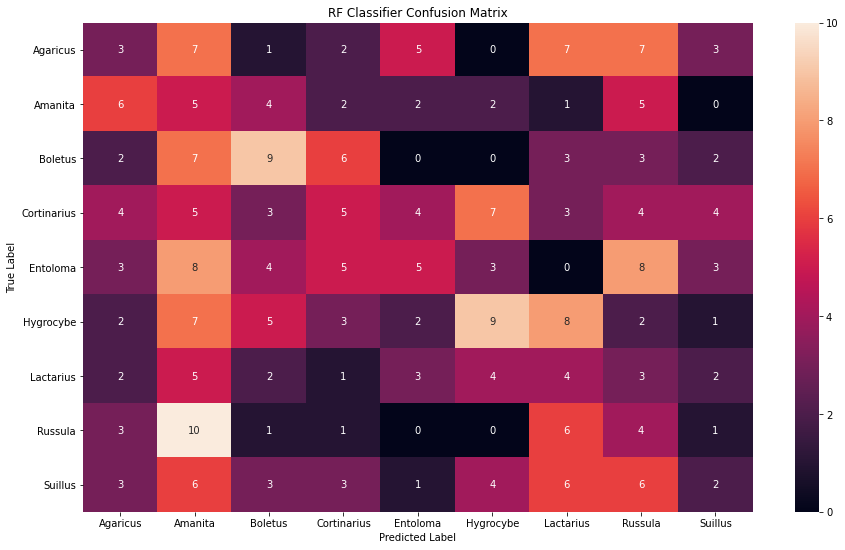

In [36]:
fig = plt.figure(figsize=(15, 9))

plot_confusion_matrix(df["Label"], y_test, rfc_pred, 'RF Classifier')

# Modelling with augmentation

## Reduction with PCA

In [37]:
scaler = MinMaxScaler()
le = LabelEncoder()

pca = PCA(n_components=100)

In [38]:
images = [np.ravel(image) for image in images_aug]

images_scaled = scaler.fit_transform(images)
labels_encoded = le.fit_transform(labels_aug)

In [39]:
images_pca = pca.fit_transform(images_scaled, labels_encoded)

images_pca_df = pd.DataFrame(data=images_pca)
images_pca_df["Label"] = le.inverse_transform(labels_encoded)

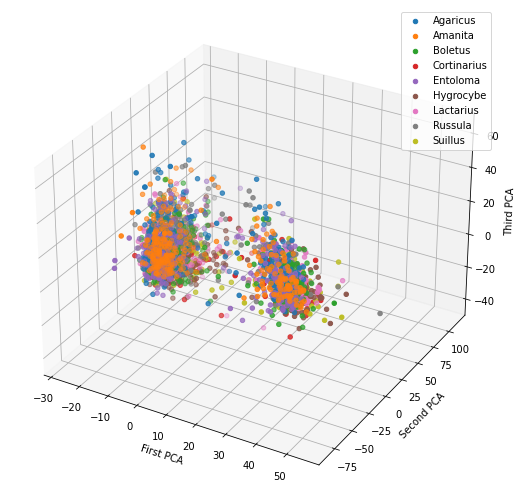

In [40]:
fig = plt.figure(figsize=(15,9))

ax = fig.add_subplot(projection='3d')

for label in images_pca_df["Label"].unique():
    first_pca = images_pca_df[images_pca_df["Label"] == label][0]
    second_pca = images_pca_df[images_pca_df["Label"] == label][1]
    third_pca = images_pca_df[images_pca_df["Label"] == label][2]
    
    ax.scatter(first_pca, second_pca, third_pca, label=label)
    
ax.legend()

ax.set_xlabel("First PCA")
ax.set_ylabel("Second PCA")
ax.set_zlabel("Third PCA")

plt.show()

## Modelling

In [41]:
X = images_pca_df.drop(columns=["Label"])
y = pd.Series(le.fit_transform(images_pca_df["Label"]))

### Using train_test_split

In [42]:
selection = ModelSelection(X, y, [RandomForestClassifier(), DecisionTreeClassifier(), MLPClassifier(), SVC()])

In [43]:
selection.use_train_test_split()

Model info
--------------------
Model name : RandomForestClassifier
Model name : DecisionTreeClassifier
Model name : MLPClassifier
Model name : SVC

Training models
--------------------
Done Training RandomForestClassifier in time:2.0911614894866943
Done Training DecisionTreeClassifier in time:2.3573904037475586


C:\Users\Bina Umat\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Done Training MLPClassifier in time:7.565070152282715
Done Training SVC in time:9.849928379058838
--------------------
Done Training models in time : 9.849928379058838


The Scores :

Train RandomForestClassifier score : 1.0
Train DecisionTreeClassifier score : 1.0
Train MLPClassifier score : 1.0
Train SVC score : 0.824212271973466
----------
Test RandomForestClassifier score : 0.7901234567901234
Test DecisionTreeClassifier score : 0.37485970819304154
Test MLPClassifier score : 0.696969696969697
Test SVC score : 0.4781144781144781
----------
Bias RandomForestClassifier score : 0.2098765432098766
Bias DecisionTreeClassifier score : 0.6251402918069584
Bias MLPClassifier score : 0.303030303030303
Bias SVC score : 0.3460977938589879
----------


### Using StratifiedKFold

In [44]:
selection = ModelSelection(X, y, [RandomForestClassifier(), DecisionTreeClassifier(), MLPClassifier(), SVC()])

In [45]:
selection.use_stratifiedkfold()

Fold 1
----------

Training models

--------------------
Done Training RandomForestClassifier in time:2.714832305908203

The Scores :

Train RandomForestClassifier score : 1.0
Test RandomForestClassifier score : 0.8759259259259259
Bias RandomForestClassifier score : 0.12407407407407411

--------------------
Done Training DecisionTreeClassifier in time:3.024815082550049

The Scores :

Train DecisionTreeClassifier score : 1.0
Test DecisionTreeClassifier score : 0.4351851851851852
Bias DecisionTreeClassifier score : 0.5648148148148149

--------------------
Done Training MLPClassifier in time:10.17037296295166

The Scores :

Train MLPClassifier score : 1.0
Test MLPClassifier score : 0.8574074074074074
Bias MLPClassifier score : 0.1425925925925926

--------------------
Done Training SVC in time:12.798213005065918

The Scores :

Train SVC score : 0.8351851851851851
Test SVC score : 0.5648148148148148
Bias SVC score : 0.27037037037037037
--------------------
Done Training models in time : 12.

C:\Users\Bina Umat\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(



--------------------
Done Training MLPClassifier in time:9.967721939086914

The Scores :

Train MLPClassifier score : 1.0
Test MLPClassifier score : 0.8629629629629629
Bias MLPClassifier score : 0.13703703703703707

--------------------
Done Training SVC in time:12.197466373443604

The Scores :

Train SVC score : 0.8356481481481481
Test SVC score : 0.5740740740740741
Bias SVC score : 0.26157407407407407
--------------------
Done Training models in time : 12.197466373443604

Fold 3
----------

Training models

--------------------
Done Training RandomForestClassifier in time:2.3408374786376953

The Scores :

Train RandomForestClassifier score : 1.0
Test RandomForestClassifier score : 0.8888888888888888
Bias RandomForestClassifier score : 0.11111111111111116

--------------------
Done Training DecisionTreeClassifier in time:2.627967119216919

The Scores :

Train DecisionTreeClassifier score : 1.0
Test DecisionTreeClassifier score : 0.4185185185185185
Bias DecisionTreeClassifier score : 

## Evaluation

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [47]:
svm = SVC(probability=True)
dtc = DecisionTreeClassifier()
mlpc = MLPClassifier()
rfc = RandomForestClassifier()

In [48]:
svm.fit(X_train, y_train)
dtc.fit(X_train, y_train)
mlpc.fit(X_train, y_train)
rfc.fit(X_train, y_train)

C:\Users\Bina Umat\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


RandomForestClassifier()

### ROC Curve and AUC

In [49]:
svm_proba = svm.predict_proba(X_test)
dtc_proba = dtc.predict_proba(X_test)
mlpc_proba = mlpc.predict_proba(X_test)
rfc_proba = rfc.predict_proba(X_test)

In [50]:
fprs_svm, tprs_svm, aucs_svm = calc_roc_curve(y_test, svm_proba)
fprs_dtc, tprs_dtc, aucs_dtc = calc_roc_curve(y_test, dtc_proba)
fprs_mlpc, tprs_mlpc, aucs_mlpc = calc_roc_curve(y_test, mlpc_proba)
fprs_rfc, tprs_rfc, aucs_rfc = calc_roc_curve(y_test, rfc_proba)

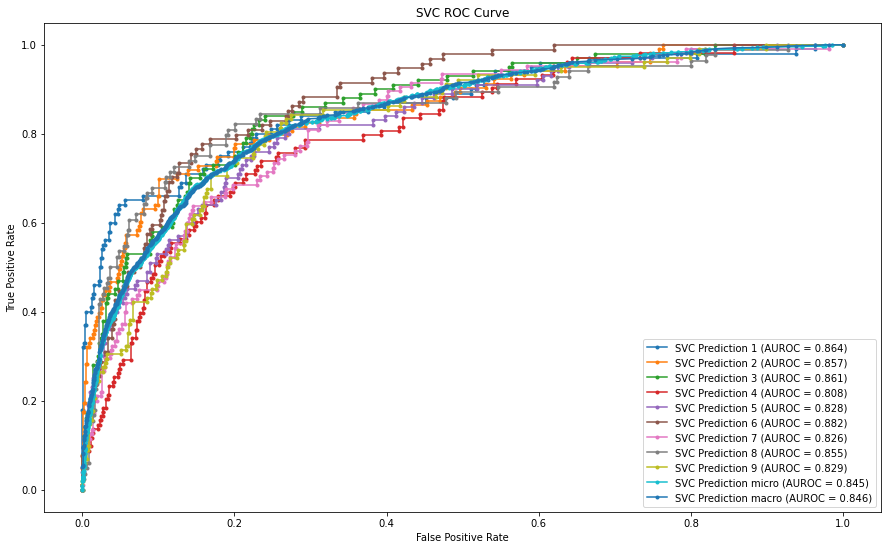

In [51]:
fig = plt.figure(figsize=(15, 9))

plot_roc_curve(fprs_svm, tprs_svm, aucs_svm, "SVC")

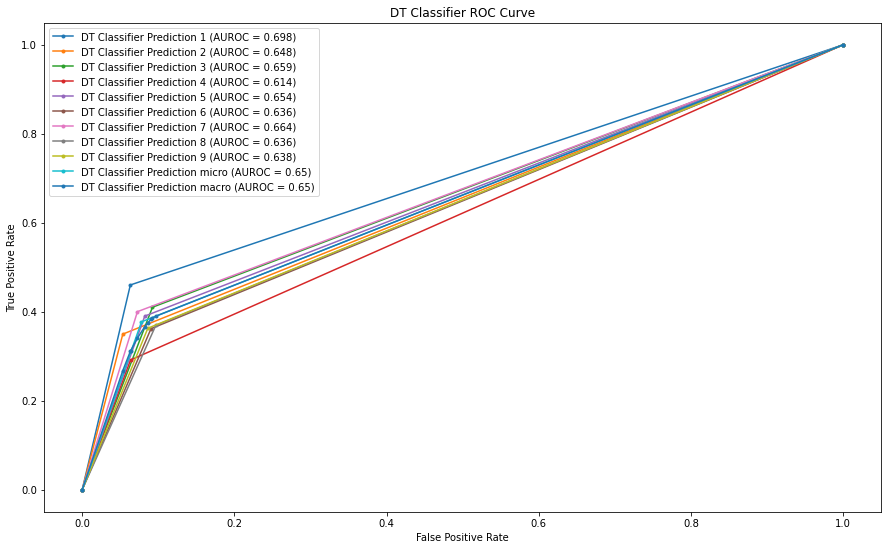

In [52]:
fig = plt.figure(figsize=(15, 9))

plot_roc_curve(fprs_dtc, tprs_dtc, aucs_dtc, "DT Classifier")

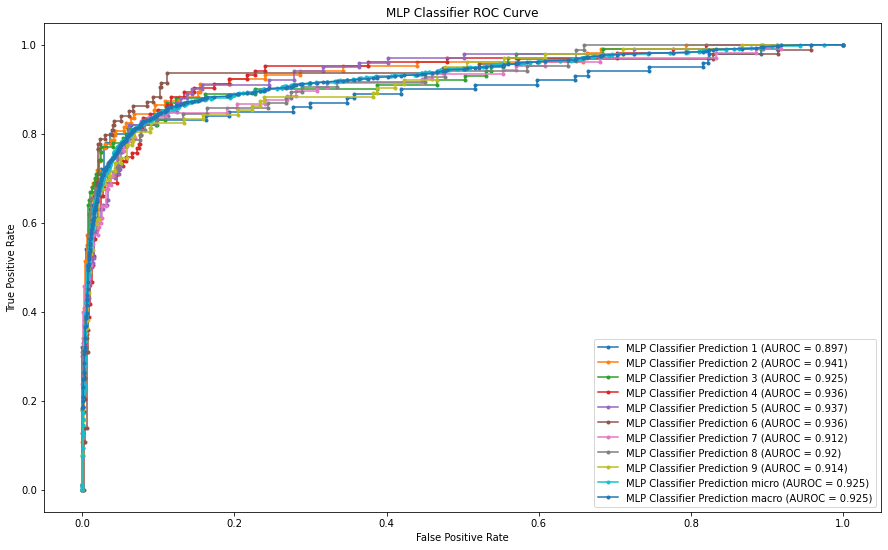

In [53]:
fig = plt.figure(figsize=(15, 9))

plot_roc_curve(fprs_mlpc, tprs_mlpc, aucs_mlpc, "MLP Classifier")

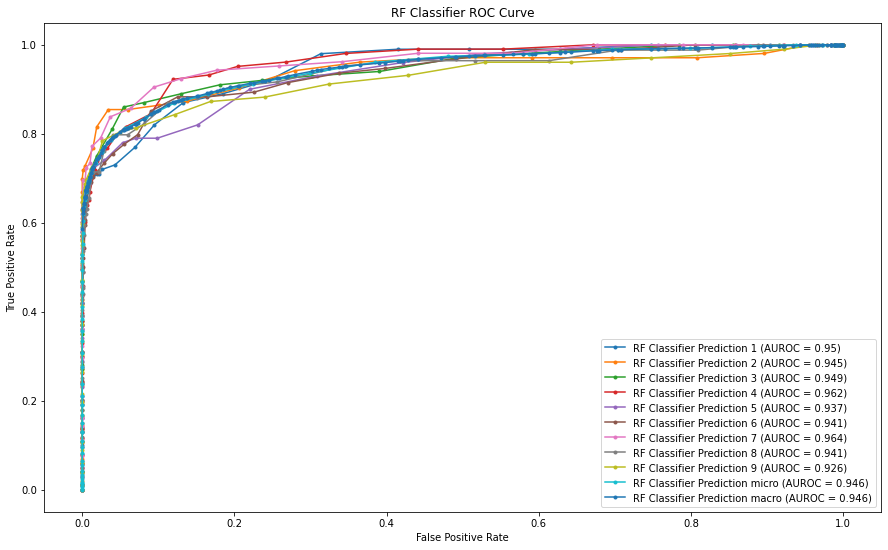

In [54]:
fig = plt.figure(figsize=(15, 9))

plot_roc_curve(fprs_rfc, tprs_rfc, aucs_rfc, "RF Classifier")

### Confusion Matrix

In [55]:
svm_pred = svm.predict(X_test)
dtc_pred = dtc.predict(X_test)
mlpc_pred = mlpc.predict(X_test)
rfc_pred = rfc.predict(X_test)

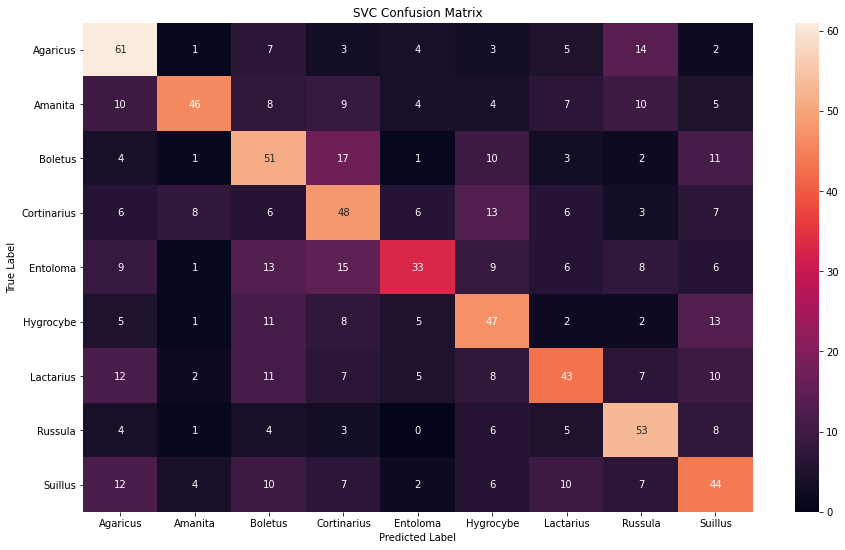

In [56]:
fig = plt.figure(figsize=(15, 9))

plot_confusion_matrix(df["Label"], y_test, svm_pred, 'SVC')

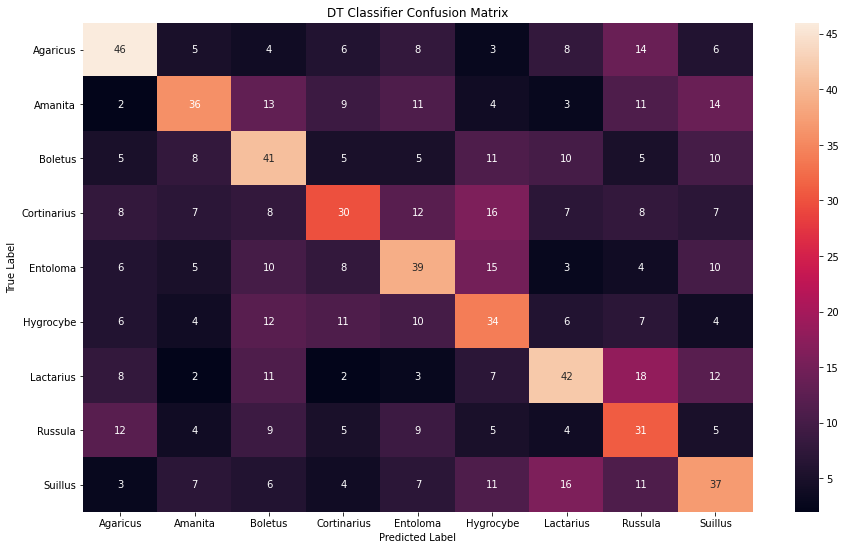

In [57]:
fig = plt.figure(figsize=(15, 9))

plot_confusion_matrix(df["Label"], y_test, dtc_pred, 'DT Classifier')

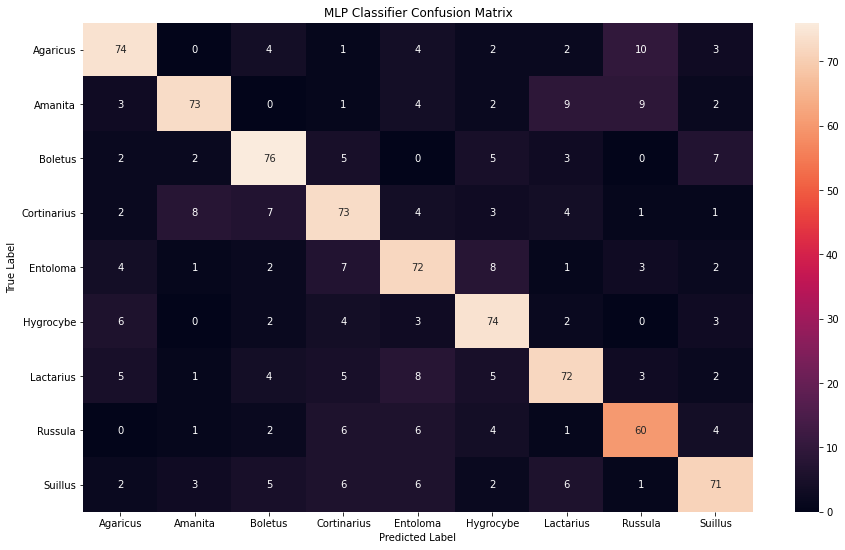

In [58]:
fig = plt.figure(figsize=(15, 9))

plot_confusion_matrix(df["Label"], y_test, mlpc_pred, 'MLP Classifier')

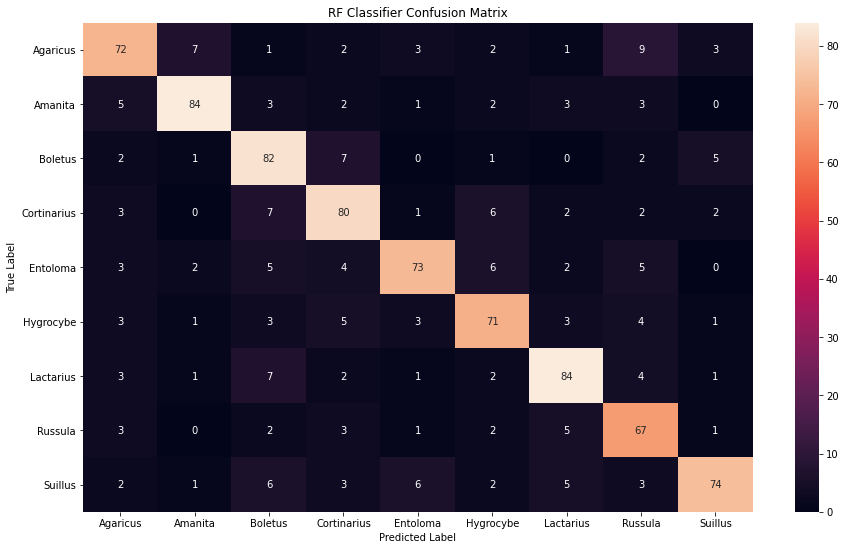

In [59]:
fig = plt.figure(figsize=(15, 9))

plot_confusion_matrix(df["Label"], y_test, rfc_pred, 'RF Classifier')